In [370]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 1]

In [371]:
# Updated version of van der Heijden et al. (2012) PNAS model for nucleosome positioning
# https://doi.org/10.1073/pnas.1205659109


def clean_up(sequence):
    sequence = sequence.upper()
    sequence = sequence.replace("U", "T")
    sequence = [base for base in sequence if base in "ACGT"]
    return "".join(sequence)


def to_index(base):
    return {"A": 0, "C": 1, "G": 2, "T": 3}.get(base)


def get_weight(width, period, amplitude):
    x = np.arange(width)
    base_probs = {
        "A": 0.25 + amplitude * np.sin(2 * np.pi * x / period),
        "C": 0.25 - amplitude * np.sin(2 * np.pi * x / period) / 3,
        "G": 0.25 - amplitude * np.sin(2 * np.pi * x / period) / 3,
        "T": 0.25 - amplitude * np.sin(2 * np.pi * x / period) / 3,
    }
    return [[base_probs[base1][i] for base1 in "ACGT"] for i in x]


def calculate_energy(sequence, width, amplitude, period):
    prob_array = np.array(get_weight(width, period, amplitude))
    base_indices = np.array([to_index(base) for base in sequence])

    probability_forward = (
        np.prod(
            prob_array[
                np.arange(width)[:, None],
                base_indices[
                    np.arange(len(sequence) - width) + np.arange(width)[:, None]
                ],
            ],
            axis=0,
        )
        * 4**width
    )

    probability_reversed = (
        np.prod(
            prob_array[
                np.arange(width)[:, None],
                3
                - base_indices[
                    np.arange(len(sequence) - width)
                    + np.arange(width - 1, -1, -1)[:, None]
                ],
            ],
            axis=0,
        )
        * 4**width
    )

    # Calculate energy average over both directions
    E = (
        probability_reversed * np.log(probability_reversed)
        + probability_forward * np.log(probability_forward)
    ) / (probability_reversed + probability_forward)
    return E


def smooth(x, window_len):
    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-1:-window_len:-1]]
    w = np.ones(window_len, "d")
    y = np.convolve(w / w.sum(), s, mode="valid")
    return y[
        len(x[window_len - 1 : 0 : -1]) : len(x[window_len - 1 : 0 : -1]) + len(x) + 1
    ]


def vanderlick(energy, mu, footprint, sequence):
    energy_out = energy - mu

    forward = np.zeros(len(energy))
    for i in range(len(energy)):
        tmp = sum(forward[max(i - footprint, 0) : i])
        forward[i] = np.exp(energy_out[i] - tmp)

    backward = np.zeros(len(energy))
    reverse_forward = forward[::-1]
    for i in range(len(energy)):
        backward[i] = 1 - sum(
            reverse_forward[max(i - footprint, 0) : i]
            * backward[max(i - footprint, 0) : i]
        )

    probability = forward * backward[::-1]

    missing_length = len(sequence) - len(probability)
    probability = np.concatenate([probability, np.zeros(missing_length)])
    probability = np.roll(probability, missing_length // 2)

    return np.clip(probability, 0, 1)


def create_sequence(contour_length, dyads_601=None):
    sequence = np.random.choice(list("ACGT"), contour_length)

    if dyads_601 is not None:
        sequence_601 = list(
            "ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG"
        )
        for dyad in dyads_601:
            start_index = max(0, dyad - len(sequence_601) // 2)
            end_index = min(contour_length, dyad + len(sequence_601) // 2)
            length = end_index - start_index
            sequence[start_index : start_index + length] = sequence_601[:length]

    sequence = "".join(sequence)
    return sequence


def calc_nucleosome_positions(sequence, width, mu, amplitude=0.21, period=10.4):
    energy_nucleosome = calculate_energy(sequence, width, amplitude, period)
    energy_smoothed = smooth(energy_nucleosome, 10)
    probability = vanderlick(energy_smoothed, mu, 147, sequence)

    occupancy = np.convolve(probability, np.ones(147), mode="same")
    return energy_nucleosome, energy_smoothed, probability, occupancy

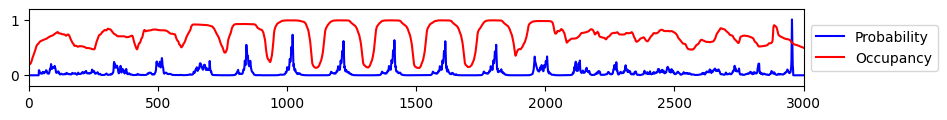

In [372]:
# Main code to run the model

in_vivo = False 
if in_vivo:
    footprint = 147
    mu = -10.5
else:  # for salt gradient reconstution
    footprint = 80
    mu = -1.5

contour_length = 3000
handle_length = 1000
dyads_601 = np.arange(handle_length, contour_length - handle_length, 197)
# dyads_601 = None
sequence = create_sequence(contour_length, dyads_601)


_, _, probability, occupacy = calc_nucleosome_positions(sequence, footprint, mu)


plt.plot(probability * 1e1, label="Probability", color="blue")
plt.plot(occupacy, label="Occupancy", color="red")
plt.xlim(0, len(sequence))
plt.ylim(-0.2, 1.2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


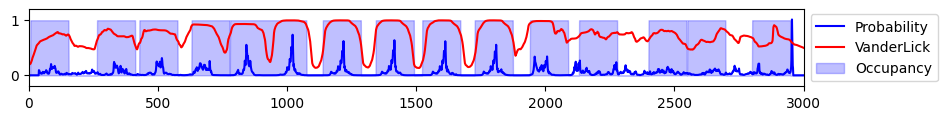

In [474]:
# Generate single instances of a chroamtin fiber based on the probability distribution


def create_mask(size, center, width, invert=False):
    mask = np.zeros(size, dtype=int)
    start = max(0, center - width // 2)
    end = min(size, start + width + 1)

    mask[start:end] = 1
    if invert:
        mask = 1 - mask
    return mask


def get_single_fiber(probability, width=147, max_n=None):
    if max_n is None:
        max_n = len(probability) // width

    dyads = []
    probability[: width // 2] = 0
    probability[-width // 2 :] = 0


    for i in range(max_n):
        if probability.sum() == 0 or len(dyads) >= max_n:
            break  # Stop if no valid positions are left

        probability = probability / probability.sum()
        dyads.append(np.random.choice(len(probability), p=probability))
        probability *= create_mask(len(probability), dyads[-1], width * 2, invert=True)

    return np.asarray(sorted(dyads))


def calculate_occupancy(probability, dyads, width=147):
    occupancy = np.zeros_like(probability)
    for dyad in dyads:
        occupancy += create_mask(len(occupancy), dyad, width)
    return occupancy



dyads = get_single_fiber(probability.copy(), max_n=200)
fiber_occupancy = calculate_occupancy(probability, dyads)

plt.plot(probability * 1e1, label="Probability", color="blue")
plt.plot(occupacy, "r", label="VanderLick")
plt.fill_between(
    np.arange(len(occupacy)),
    fiber_occupancy,
    color="blue",
    label="Occupancy",
    alpha=0.25,
)
plt.xlim(0, len(sequence))
plt.ylim(-0.2, 1.2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

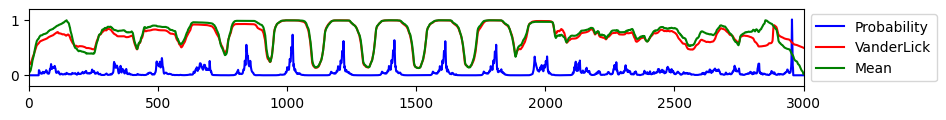

In [476]:
# Compare mean of individual fibers with Vanderlick model
n = 1000

average_occupancy = np.zeros_like(probability)

for i in range(n):
    dyads = get_single_fiber(probability.copy(), footprint)
    average_occupancy += calculate_occupancy(probability, dyads, footprint)
average_occupancy /= n

plt.plot(probability * 1e1, label="Probability", color="blue")
plt.plot(occupacy, "r", label="VanderLick")
plt.plot(average_occupancy, "g", label="Mean")
plt.xlim(0, len(sequence))
plt.ylim(-0.2, 1.2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

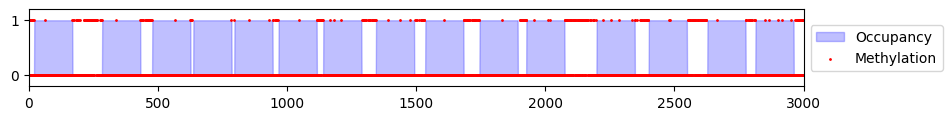

In [478]:
def methylate(sequence, dyads, footprint, methylation_rate=0.8, decay_length=30, targets=["A", "T"]):
    sequence = np.array(list(sequence))
    methylated = np.zeros(len(sequence), dtype=int)
    target_mask = np.isin(sequence, targets)

    # Compute distances to the nearest dyad for all positions
    distances = np.min(np.abs(dyads[:, None] - np.arange(len(sequence))), axis=0)

    # Calculate methylation probabilities
    probabilities = np.where(
        distances > footprint // 2,
        methylation_rate,
        methylation_rate * 0.1 * np.exp(-distances / decay_length)
    )

    # Apply methylation based on probabilities
    random_values = np.random.rand(len(sequence))
    methylated = (random_values < probabilities) & target_mask

    return methylated


dyads = get_single_fiber(probability.copy())
fiber_occupancy = calculate_occupancy(probability, dyads)

methylated = methylate(sequence, dyads, 147)

plt.fill_between(
    np.arange(len(occupacy)),
    fiber_occupancy,
    color="blue",
    label="Occupancy",
    alpha=0.25,
)
plt.scatter(np.arange(len(sequence)), methylated, color="red", s=1, label="Methylation")
plt.xlim(0, len(sequence))
plt.ylim(-0.2, 1.2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

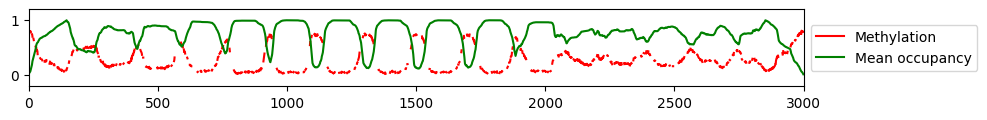

In [482]:
n = 1000
average_methylated = np.zeros_like(probability)
average_occupancy = np.zeros_like(probability)

for i in range(n):
    dyads = get_single_fiber(probability.copy(), footprint)
    average_methylated += methylate(sequence, dyads, 132, decay_length=30)
    average_occupancy += calculate_occupancy(probability, dyads, footprint)

average_methylated /= n
average_occupancy /= n

average_methylated[average_methylated == 0] = np.nan

plt.plot(average_methylated, color="red", label="Methylation")
plt.plot(average_occupancy, "g", label="Mean occupancy")

plt.xlim(0, len(sequence))
plt.ylim(-0.2, 1.2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()